# Frozen Lake

In [1]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils
from gym.envs.toy_text import discrete
from gym.envs.registration import register

# Modified from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py to give -1 reward at holes

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class UpdatedFrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="8x8", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (-1, 0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            reward = 0
            if newletter == b"G":
                reward = 1
            elif newletter == b"H":
                reward = -1
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        super().__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [2]:
from hiive.mdptoolbox import example
import gym

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
from hiive.mdptoolbox import mdp


# Copied from https://github.com/hiive/hiivemdptoolbox/pull/3/files
class OpenAI_MDPToolbox:

    """Class to convert Discrete Open AI Gym environemnts to MDPToolBox environments. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    """

    def __init__(self, env, render:bool=False, **kwargs):
        """Create a new instance of the OpenAI_MDPToolbox class
        :param openAI_env_name: Valid name of an Open AI Gym env 
        :type openAI_env_name: str
        :param render: whether to render the Open AI gym env
        :type rander: boolean 
        """
        self.env = env
        self.env.reset()

        if render:
            self.env.render()

        self.transitions = self.env.P
        self.actions = int(re.findall(r'\d+', str(self.env.action_space))[0])
        self.states = int(re.findall(r'\d+', str(self.env.observation_space))[0])
        self.P = np.zeros((self.actions, self.states, self.states))
        self.R = np.zeros((self.states, self.actions))
        self.convert_PR()

    def convert_PR(self):
        """Converts the transition probabilities provided by env.P to MDPToolbox-compatible P and R arrays
        """
        for state in range(self.states):
            for action in range(self.actions):
                for i in range(len(self.transitions[state][action])):
                    tran_prob = self.transitions[state][action][i][0]
                    state_ = self.transitions[state][action][i][1]
                    self.R[state][action] += tran_prob*self.transitions[state][action][i][2]
                    self.P[action, state, state_] += tran_prob

In [3]:
def openai(env, render:bool=False, **kwargs):
    """
    Generate a MDPToolbox-formatted version of a *discrete* OpenAI Gym environment. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    This function is used to generate a transition probability
    (``A`` × ``S`` × ``S``) array ``P`` and a reward (``S`` × ``A``) matrix
    ``R``.
    Parameters
    ---------
    env_name : str
        The name of the Open AI gym environment to model. 
    render : bool 
        Flag to render the environment via gym's `render()` function. 
    
    Returns
    -------
    out : tuple
        ``out[0]`` contains the transition probability matrix P  and ``out[1]``
        contains the reward matrix R. 
    Examples
    --------
    >>> import hiive.mdptoolbox.example
    >>> from gym.envs.toy_text.frozen_lake import generate_random_map
    >>> random_map = generate_random_map(size=10, p=0.98)
    >>> P, R = hiive.mdptoolbox.example.openai("FrozenLake-v0", desc=random_map)
    >>> P
    array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
    <BLANKLINE> 
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]])
    >>> R
    array([[ -1.,  -1.,  -1.,  -1.,  -1., -10.],
       [ -1.,  -1.,  -1.,  -1.,  -1., -10.],
       [ -1.,  -1.,  -1.,  -1.,  -1., -10.],
       ...,
       [ -1.,  -1.,  -1.,  -1., -10., -10.],
       [ -1.,  -1.,  -1.,  -1., -10., -10.],
       [ -1.,  -1.,  -1.,  -1., -10., -10.]])
    >>> P, R = hiive.mdptoolbox.example.openai("Taxi-v3", True)
    +---------+
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+`
    """

    envR = OpenAI_MDPToolbox(env, render, **kwargs)
    return envR.P, envR.R

In [4]:
from gym.envs.toy_text import frozen_lake
env2 = UpdatedFrozenLakeEnv()
env2.seed(0)
P, R = openai(env2)
env2.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [5]:
def run_tests(policy):
    env2.seed(0)
    env2.reset()
    max_steps = 1000
    rewards = []
    steps = []
    for episode in range(1000):
        reward_per_ep = []
        env2.seed(episode)
        state = env2.reset()
        step = 0
        done = False

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = policy[state]

            new_state, reward, done, info = env2.step(action)
            reward_per_ep.append(reward)

            if done:
                steps.append(step)
                break
            state = new_state

        rewards.append(np.sum(reward_per_ep))
    env2.close()
    return np.mean(rewards)

In [6]:
def run_policy_iteration_for_frozen(P, R):
    gamma_range = [0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
    rewards = []
    mpl.figure(figsize=(15,10))
    for gamma in gamma_range:
        pi = mdp.PolicyIteration(P, R, gamma)
        pi.run()
        df = pd.DataFrame(pi.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Gamma: {:.2f}".format(gamma))
        rewards.append([gamma, pi.iter, pi.time ,run_tests(pi.policy)])
    mpl.title("Utility vs Iteration for Policy Iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    return rewards

[[0.05, 5, 0.030997753143310547, 0.808],
 [0.1, 5, 0.00996851921081543, 0.808],
 [0.2, 5, 0.0049648284912109375, 0.808],
 [0.5, 5, 0.009997367858886719, 0.824],
 [0.7, 5, 0.009996652603149414, 0.824],
 [0.9, 5, 0.01999807357788086, 0.828],
 [0.99, 1000, 1.285465955734253, 0.986]]

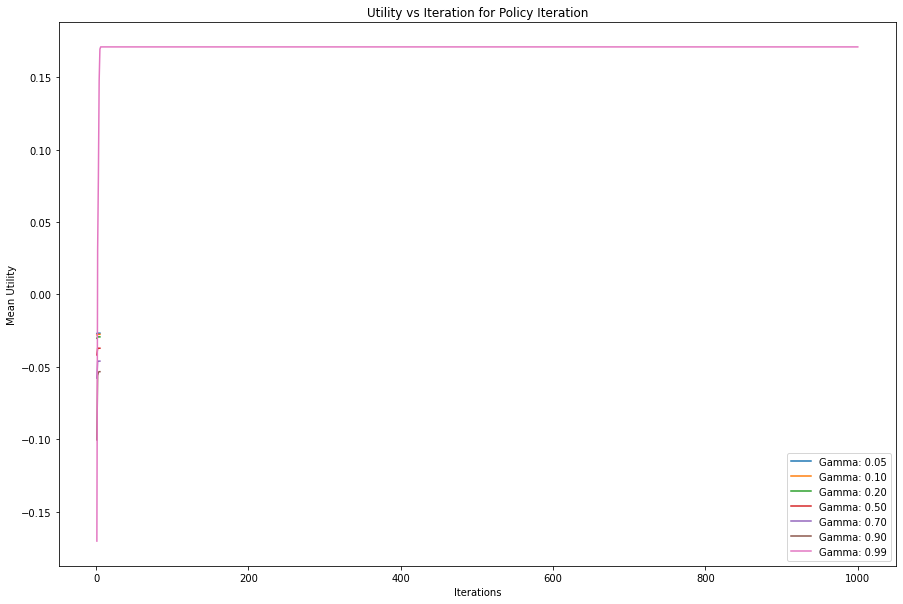

In [7]:
run_policy_iteration_for_frozen(P, R)

In [8]:
def run_value_iteration_for_frozen(P, R):
    gamma_range = [0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
    rewards = []
    mpl.figure(figsize=(15,10))
    for gamma in gamma_range:
        vi = mdp.ValueIteration(P, R, gamma)
        vi.run()
        df = pd.DataFrame(vi.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Gamma: {:.2f}".format(gamma))
        rewards.append([gamma, vi.iter, vi.time ,run_tests(vi.policy)])
    mpl.title("Utility vs Iteration for Value Iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    return rewards

[[0.05, 1, 0.0, 0.0],
 [0.1, 1, 0.0, 0.0],
 [0.2, 2, 0.0, 0.0],
 [0.5, 5, 0.0009667873382568359, 0.0],
 [0.7, 9, 0.005001068115234375, 0.0],
 [0.9, 25, 0.0, 0.824],
 [0.99, 253, 0.009992361068725586, 0.988]]

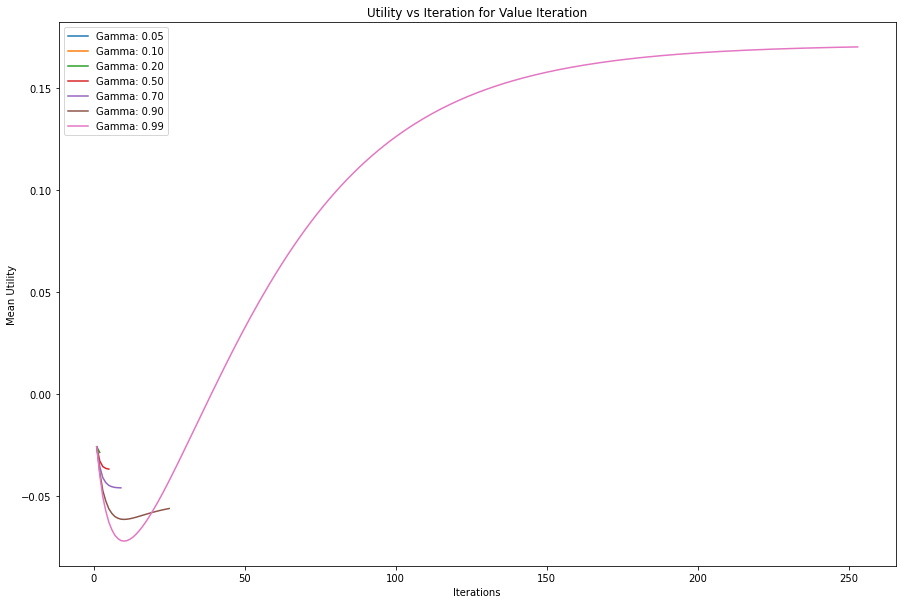

In [9]:
run_value_iteration_for_frozen(P, R)

In [10]:
def run_q_learning_for_frozen(P, R):
    frozen_map = MAPS['8x8']
    def callbac(old_s, action, new_s):
        row = new_s // 8
        column = new_s % 8
        if(frozen_map[row][column] == 'H' or frozen_map[row][column] == 'G'):
            return True
        else:
            return False
    alpha_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 0.99]
    mpl.figure(figsize=(15,10))
    max_min_v = -np.inf
    best_alpha = 0
    rerun_episodes = 100
    for alpha in alpha_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=alpha, iter_callback=callbac, n_iter=10000)
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Alpha: {:.2f}".format(alpha))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_alpha = alpha
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning alpha iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    alpha_decay_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 0.99]
    mpl.figure(figsize=(15,10))
    max_min_v = -np.inf
    best_alpha_decay = 0
    for alpha_decay in alpha_decay_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=best_alpha, alpha_decay=alpha_decay, iter_callback=callbac, n_iter=10000)
        
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Alpha decay: {:.2f}".format(alpha_decay))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_alpha_decay = alpha
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning alpha decay iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    
    epsilon_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95]
    mpl.figure(figsize=(15,10))
    max_min_v = -np.inf
    best_epsilon = 0
    for epsilon in epsilon_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=best_alpha, alpha_decay=best_alpha_decay, epsilon=epsilon, iter_callback=callbac, n_iter=10000)
        
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Epsilon: {:.2f}".format(epsilon))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_epsilon = epsilon
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning epsilon iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    print(best_alpha, best_alpha_decay, best_epsilon)
    epsilon_decay_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95]
    mpl.figure(figsize=(15,10))
    max_min_v = -np.inf
    best_epsilon_decay = 0
    for epsilon_decay in epsilon_decay_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=best_alpha, alpha_decay=best_alpha_decay, epsilon=best_epsilon, epsilon_decay=epsilon_decay, iter_callback=callbac, n_iter=10000)
        
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Epsilon decay: {:.2f}".format(epsilon_decay))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_epsilon_decay = epsilon_decay
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning epsilon decay iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    gamma_range = [0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
    rewards = []
    mpl.figure(figsize=(15,10))
    for gamma in gamma_range:
        ql = mdp.QLearning(P, R, gamma, alpha=best_alpha, alpha_decay=best_alpha_decay, epsilon=best_epsilon, epsilon_decay=best_epsilon_decay, iter_callback=callbac, n_iter=10000)
        
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Gamma: {:.2f}".format(gamma))
        rewards.append([gamma, ql.time , run_tests(ql.policy)])
    mpl.title("Utility vs Iteration for Q Learning")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    return rewards

0.01 0.99 0.1


[[0.05, 0.5072805881500244, 0.027],
 [0.1, 0.480074405670166, 0.855],
 [0.2, 0.5438747406005859, 0.047],
 [0.5, 0.511472225189209, 0.69],
 [0.7, 0.5021789073944092, 0.942],
 [0.9, 0.5256574153900146, 0.518],
 [0.99, 0.525766134262085, 0.173]]

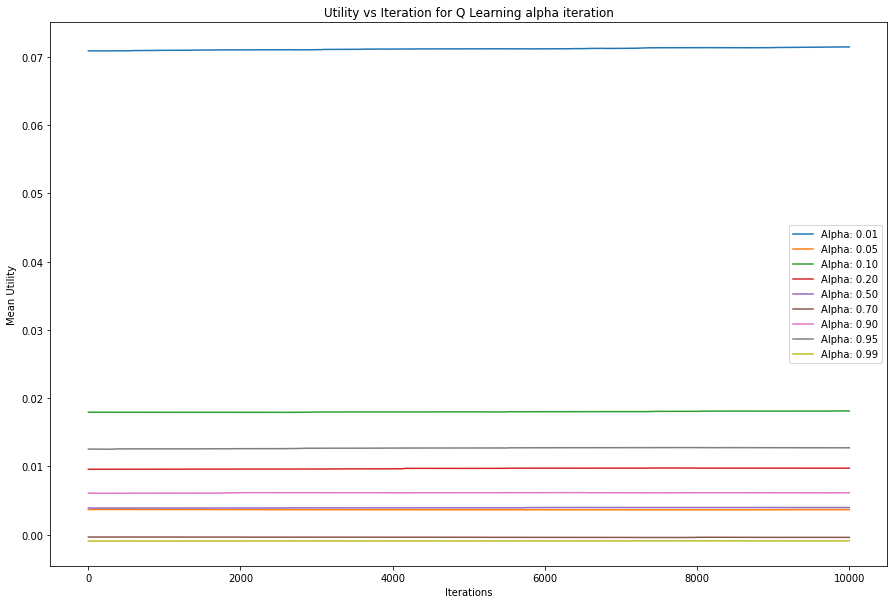

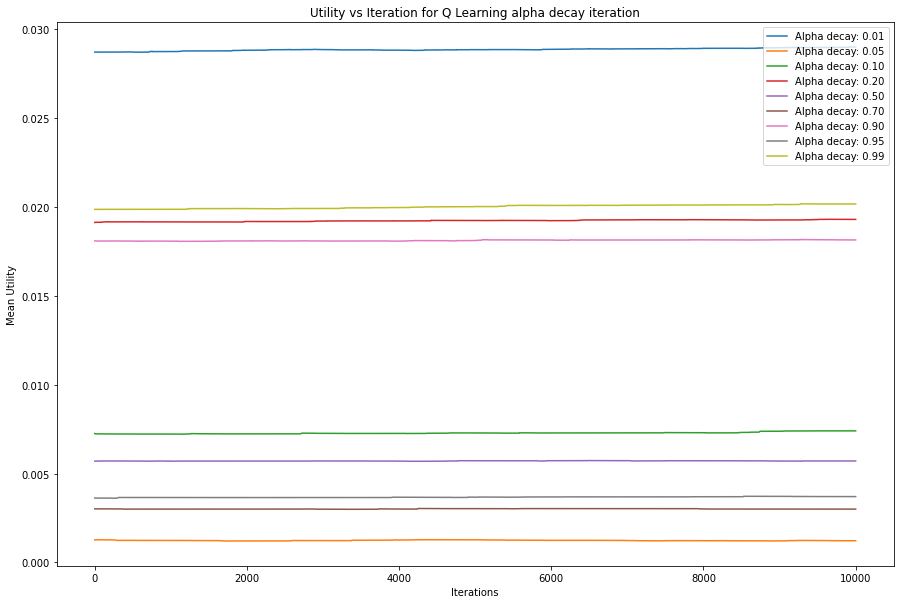

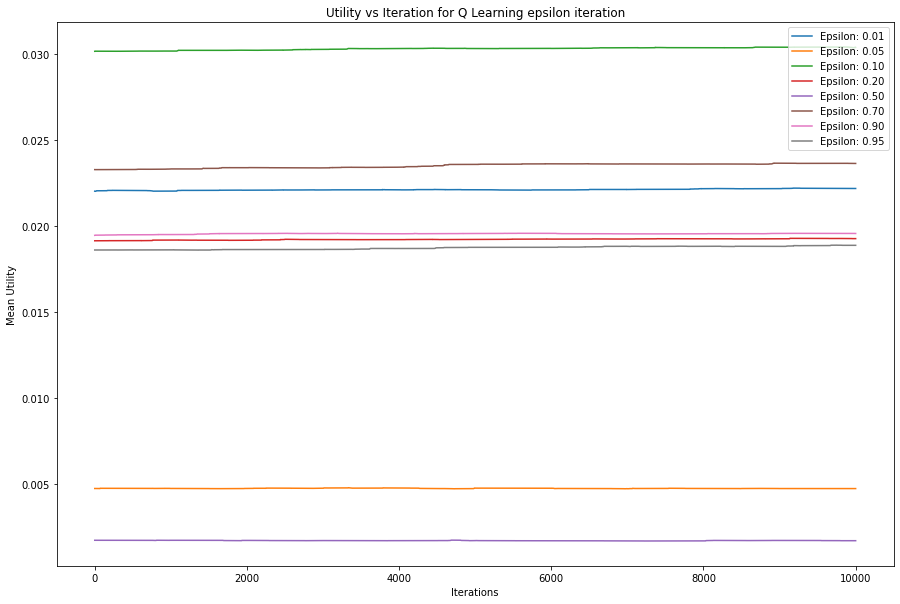

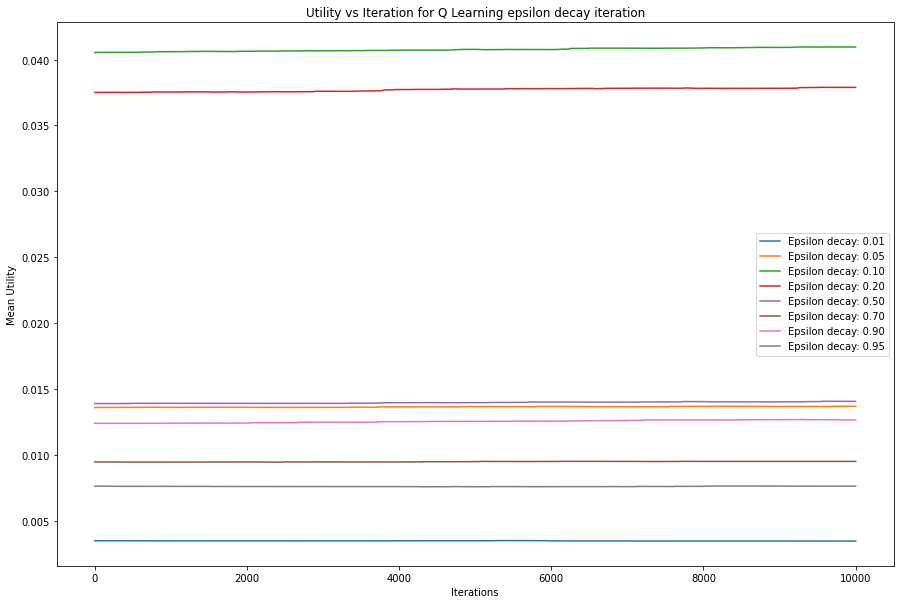

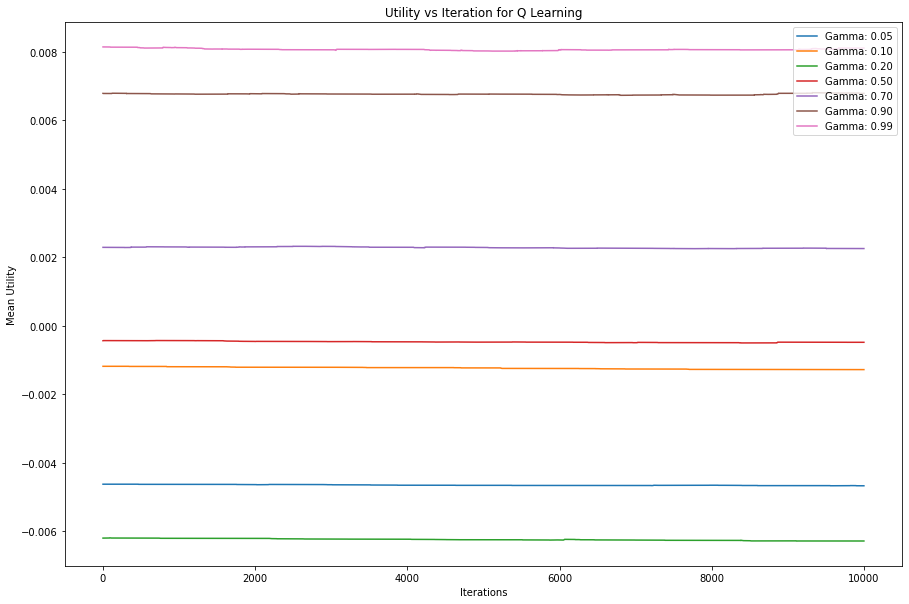

In [11]:
run_q_learning_for_frozen(P, R)

# Forest Management

In [12]:
def get_policy_reward(P, R, policy, gamma = 0.9):
    np.random.seed(0)
    total_states = R.shape[0]
    num_tries = 100
    total_reward = 0
    
    for state in range(total_states):
        reward = 0
        for i in range(num_tries):
            next_state = total_states
            discount = 1
            while next_state != 0:
                action = policy[state]
                trans_prob = P[action][state]
                next_state = np.random.choice(np.arange(total_states), 1, p=trans_prob)[0]
                reward += R[state][action] * discount
                discount *= gamma
        total_reward += (reward / num_tries)
    return total_reward / total_states

In [13]:
def run_policy_iteration_for_forest(P, R):
    gamma_range = [0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
    rewards = []
    mpl.figure(figsize=(15,10))
    for gamma in gamma_range:
        pi = mdp.PolicyIteration(P, R, gamma)
        pi.run()
        df = pd.DataFrame(pi.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Gamma: {:.2f}".format(gamma))
        rewards.append([gamma, pi.iter, pi.time ,get_policy_reward(P, R, pi.policy, gamma)])
    mpl.title("Utility vs Iteration for Policy Iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    return rewards

[[0.05, 1, 0.04699850082397461, 1.0043624351154992],
 [0.1, 1, 0.017083406448364258, 1.0047565011124941],
 [0.2, 1, 0.022702455520629883, 1.0056592757775238],
 [0.5, 2, 0.09284305572509766, 1.007255888137743],
 [0.7, 4, 0.05496525764465332, 1.008103409009814],
 [0.9, 6, 0.23735475540161133, 1.0114597350634316],
 [0.99, 9, 0.12117528915405273, 1.0229306784004757]]

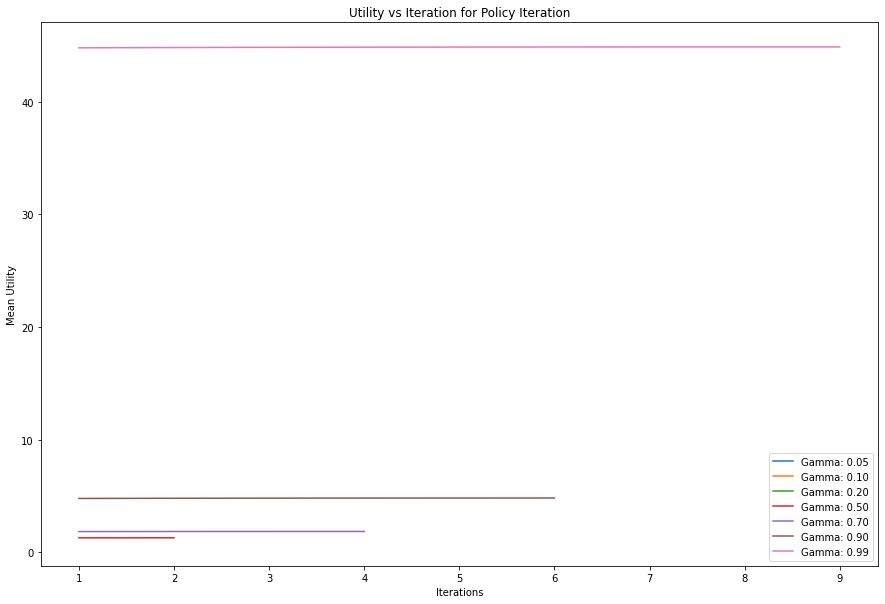

In [19]:
P, R = example.forest(S=500, p=0.2)
run_policy_iteration_for_forest(P, R)

In [20]:
def run_value_iteration_for_forest(P, R):
    gamma_range = [0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
    rewards = []
    mpl.figure(figsize=(15,10))
    for gamma in gamma_range:
        vi = mdp.ValueIteration(P, R, gamma)
        vi.run()
        df = pd.DataFrame(vi.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Gamma: {:.2f}".format(gamma))
        rewards.append([gamma, vi.iter, vi.time ,get_policy_reward(P, R, vi.policy, gamma)])
    mpl.title("Utility vs Iteration for Value Iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    return rewards

[[0.05, 1, 0.0009963512420654297, 1.0043624351154992],
 [0.1, 2, 0.0021543502807617188, 1.0047565011124941],
 [0.2, 3, 0.00034165382385253906, 1.0056592757775238],
 [0.5, 7, 0.0029997825622558594, 1.007255888137743],
 [0.7, 12, 0.004967212677001953, 1.008103409009814],
 [0.9, 25, 0.010000228881835938, 1.0114597350634316],
 [0.99, 46, 0.014967203140258789, 1.0229306784004757]]

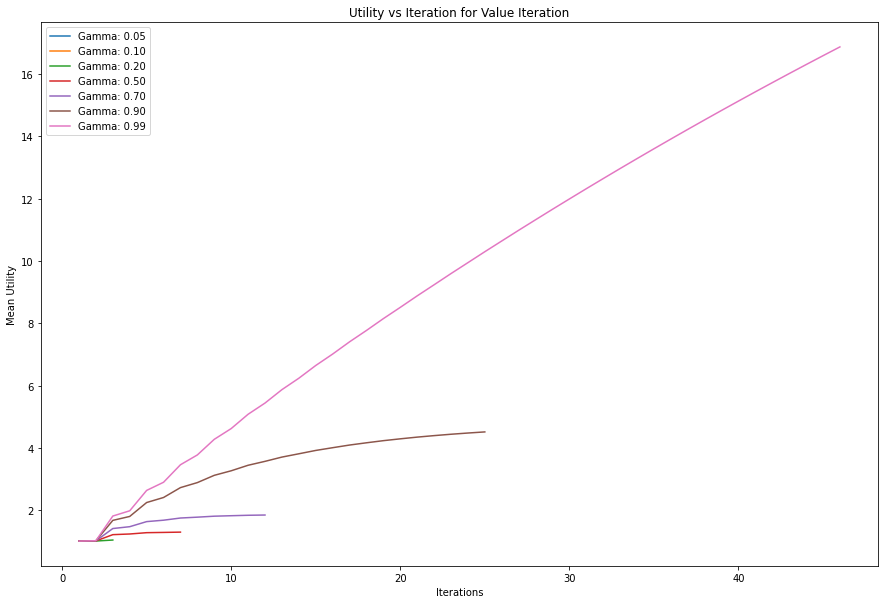

In [21]:
run_value_iteration_for_forest(P, R)

In [22]:
def run_q_learning_for_forest(P, R):
    alpha_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 0.99]
    mpl.figure(figsize=(15,10))
    max_min_v = 0
    best_alpha = 0
    rerun_episodes = 100
    for alpha in alpha_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=alpha)
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Alpha: {:.2f}".format(alpha))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_alpha = alpha
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning alpha iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    alpha_decay_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 0.99]
    mpl.figure(figsize=(15,10))
    max_min_v = 0
    best_alpha_decay = 0
    for alpha_decay in alpha_decay_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=best_alpha, alpha_decay=alpha_decay)
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Alpha decay: {:.2f}".format(alpha_decay))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_alpha_decay = alpha
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning alpha decay iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    
    epsilon_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95]
    mpl.figure(figsize=(15,10))
    max_min_v = 0
    best_epsilon = 0
    for epsilon in epsilon_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=best_alpha, alpha_decay=best_alpha_decay, epsilon=epsilon)
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Epsilon: {:.2f}".format(epsilon))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_epsilon = epsilon
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning epsilon iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    epsilon_decay_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95]
    mpl.figure(figsize=(15,10))
    max_min_v = 0
    best_epsilon_decay = 0
    for epsilon_decay in epsilon_decay_list:
        ql = mdp.QLearning(P, R, gamma=0.99, alpha=best_alpha, alpha_decay=best_alpha_decay, epsilon=best_epsilon, epsilon_decay=epsilon_decay)
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Epsilon decay: {:.2f}".format(epsilon_decay))
        if (df['Mean V'].iloc[-1] > max_min_v):
            best_epsilon_decay = epsilon_decay
            max_min_v = df['Mean V'].iloc[-1]
    mpl.title("Utility vs Iteration for Q Learning epsilon decay iteration")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    
    gamma_range = [0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
    rewards = []
    mpl.figure(figsize=(15,10))
    for gamma in gamma_range:
        ql = mdp.QLearning(P, R, gamma, alpha=best_alpha, alpha_decay=best_alpha_decay, epsilon=best_epsilon, epsilon_decay=best_epsilon_decay)
        for i in range(rerun_episodes):
            ql.run()
        df = pd.DataFrame(ql.run_stats)
        mpl.plot(df['Iteration'], df['Mean V'], label="Gamma: {:.2f}".format(gamma))
        rewards.append([gamma, ql.time ,get_policy_reward(P, R, ql.policy, gamma)])
    mpl.title("Utility vs Iteration for Q Learning")
    mpl.xlabel("Iterations")
    mpl.ylabel("Mean Utility")
    mpl.legend()
    mpl.plot()
    return rewards

[[0.05, 0.4808032512664795, 0.8083531513388778],
 [0.1, 0.49488234519958496, 0.808],
 [0.2, 0.4809994697570801, 0.7615867127414286],
 [0.5, 0.4979891777038574, 0.6795371301841736],
 [0.7, 0.497852087020874, 0.575234070935716],
 [0.9, 0.4871087074279785, 0.5305162944459275],
 [0.99, 0.4958353042602539, 0.48840993489099105]]

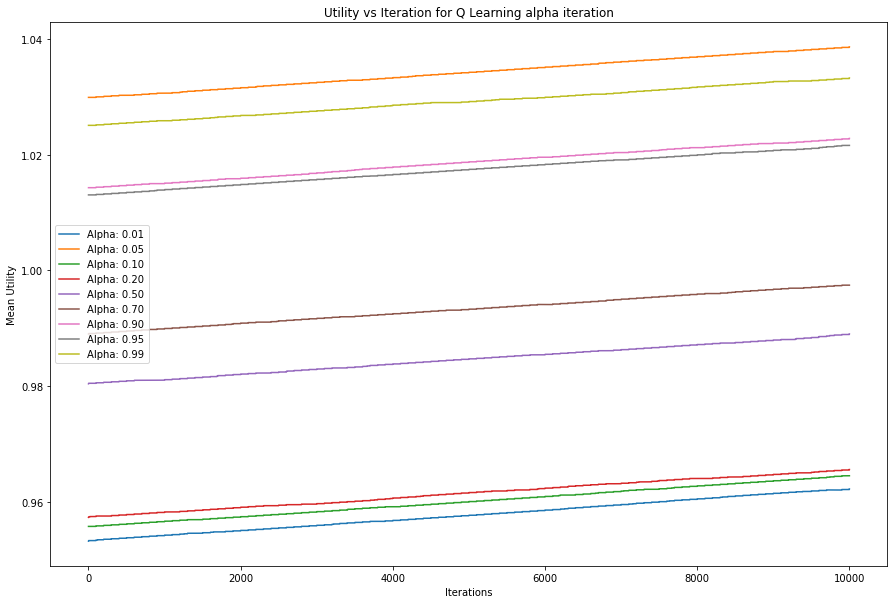

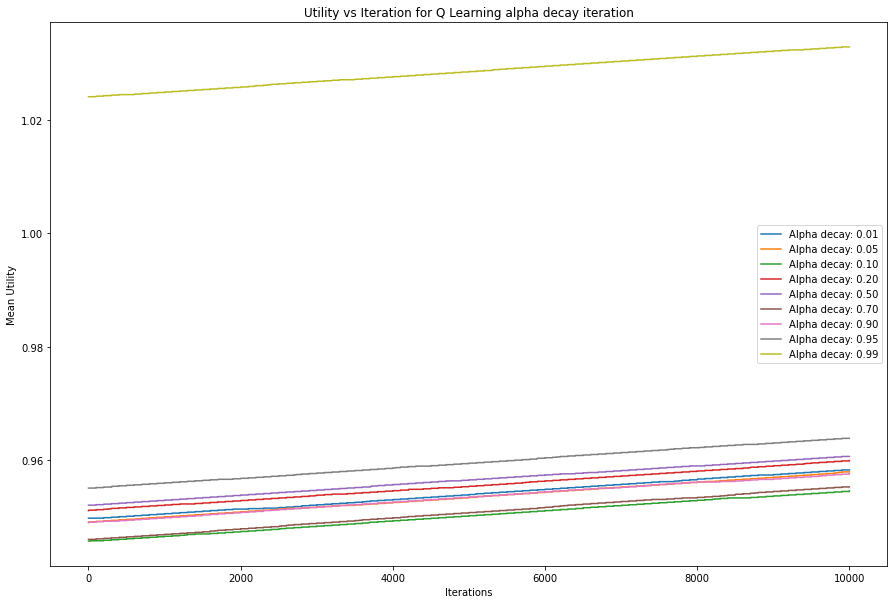

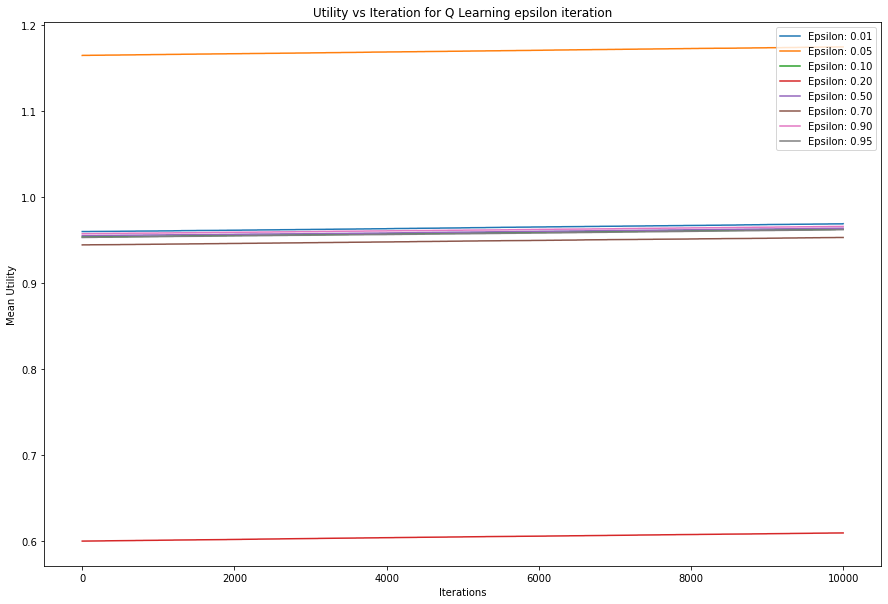

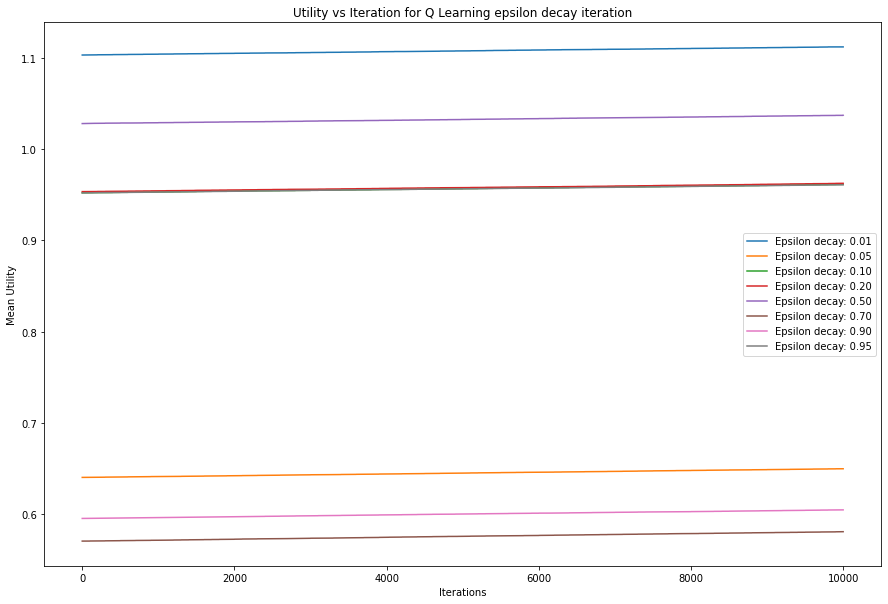

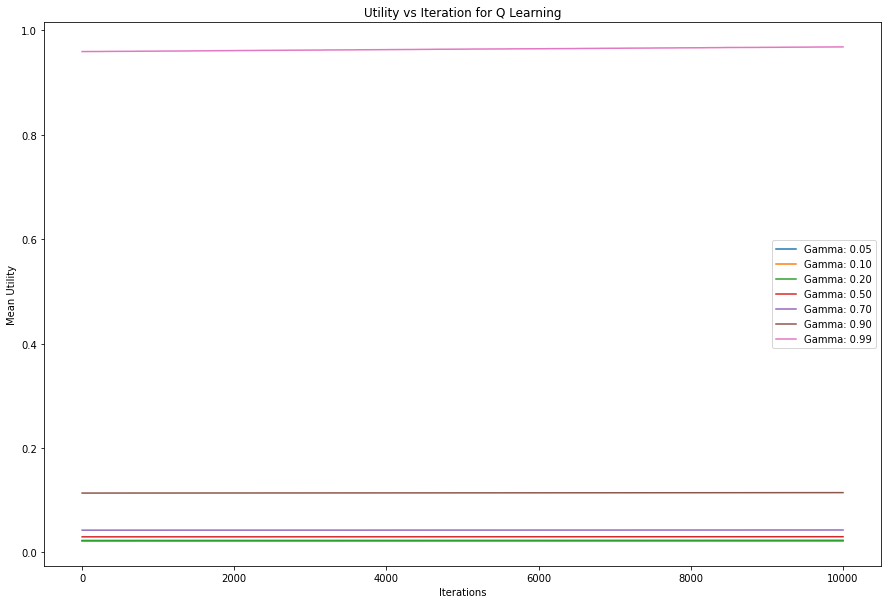

In [23]:
run_q_learning_for_forest(P, R)